In [24]:
import mlflow
import mlflow.sklearn

import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
DATA_PATH = Path() / "../final_project/data"
#DATA_PATH = Path('/content/gdrive/My Drive/Colab Notebooks/VC_data_Cleaning_With_LLM/data')
DATA_PATH.mkdir(parents=True,exist_ok=True)

def load_csv(filename, data_path=DATA_PATH,encoding='ISO-8859-1'):
    csv_path = data_path / filename
    return pd.read_csv(csv_path,encoding=encoding)

def save_csv(data, filename, data_path=DATA_PATH,encoding='ISO-8859-1'):
    csv_path = data_path / filename
    data.to_csv(csv_path, index=False,encoding='ISO-8859-1')

def load_excel(filename, data_path=DATA_PATH):
    csv_path = data_path / filename
    return pd.read_excel(csv_path)

PLOT_PATH = Path() / "../final_project/plot"
#PLOT_PATH = Path('/content/gdrive/My Drive/Colab Notebooks/VC_data_Cleaning_With_LLM/plot')
PLOT_PATH.mkdir(parents=True,exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, transparent=True):
    path = PLOT_PATH / f"{fig_id}.{fig_extension}"
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, transparent=transparent)

RESULT_PATH = Path() / "../final_project/result"
#PLOT_PATH = Path('/content/gdrive/My Drive/Colab Notebooks/VC_data_Cleaning_With_LLM/plot')
RESULT_PATH.mkdir(parents=True,exist_ok=True)
def save_result(data, filename, data_path=RESULT_PATH):
    csv_path = data_path / filename
    data.to_csv(csv_path, index=False, encoding='utf-8-sig')

def save_excel(data, filename, data_path=RESULT_PATH):
    csv_path = data_path / filename
    data.to_excel(csv_path, index=False)

import h2o

# Define the default path where models will be saved
MODEL_PATH = Path() / "../final_project/models"
MODEL_PATH.mkdir(parents=True, exist_ok=True)

def save_h2o_model(model, filename, model_path=RESULT_PATH):
    full_path = model_path / filename
    full_path.parent.mkdir(parents=True, exist_ok=True)
    saved_model_path = h2o.save_model(model=model, path=str(full_path.parent), force=True)
    print(f"Model saved to: {saved_model_path}")
    return saved_model_path

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,25 mins 51 secs
H2O_cluster_timezone:,America/Toronto
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 21 days
H2O_cluster_name:,H2O_from_python_sunnygao_u84jto
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.385 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
21:11:09.934: Project: AutoML_4_20240504_211109
21:11:09.935: 5-fold cross-validation will be used.
21:11:09.936: Setting stopping tolerance adaptively based on the training frame: 0.010447889204149373
21:11:09.936: Build control seed: 1
21:11:09.937: training frame: Frame key: AutoML_4_20240504_211109_training_py_22_sid_9045    cols: 20    rows: 9161  chunks: 1    size: 337811  checksum: -8836604592887018362
21:11:09.937: validation frame: NULL
21:11:09.937: leaderboard frame: NULL
21:11:09.937: blending frame: NULL
21:11:09.937: response column: Order Item Quantity
21:11:09.938: fold column: null
21:11:09.938: weights column: null
21:11:09.939: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (

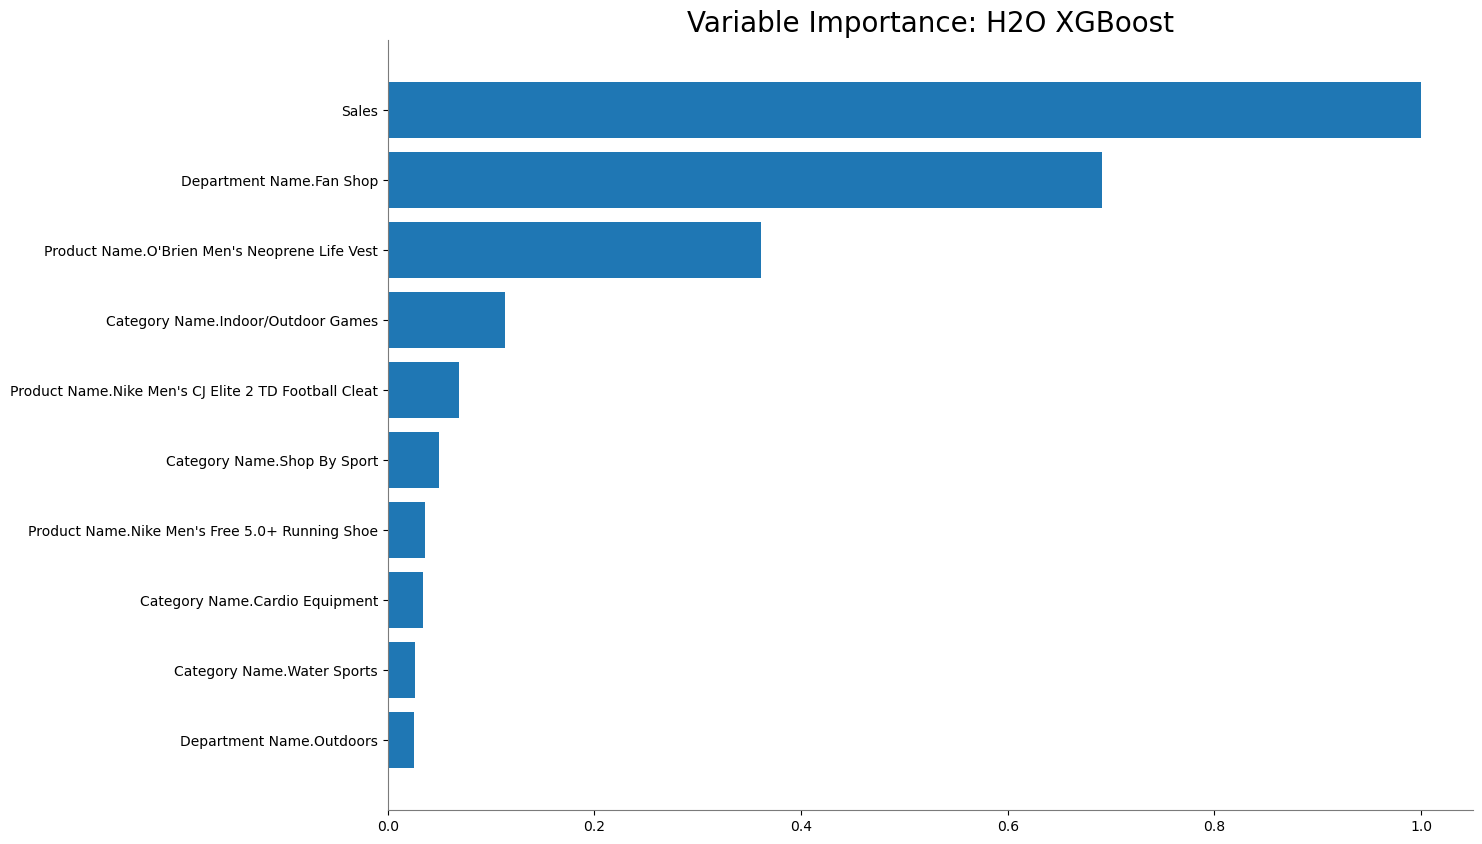

/Users/sunnygao/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


<Figure size 640x480 with 0 Axes>

In [29]:
import numpy as np
from sklearn.model_selection import train_test_split
import h2o
from h2o.automl import H2OAutoML
import mlflow
import mlflow.h2o

# Initialize H2O
h2o.init()

# Load data
df = pd.read_csv("data/Q1_2015_demand_forecast.csv")
df = df.drop(["Unnamed: 0"], axis = 1)

# H2O Frame
hf_dataset = h2o.H2OFrame(df)
train, test = hf_dataset.split_frame(ratios=[0.6], seed=1)
#test, val = test.split_frame(ratios=[0.5], seed=1)

# Define the target and features
y = "Order Item Quantity"
X = hf_dataset.columns
X.remove(y)

# Start MLflow experiment
with mlflow.start_run():
    # Configure and run H2O AutoML
    h2o_aml = H2OAutoML(max_models=12, seed=1, exclude_algos=["StackedEnsemble"], verbosity="info")
    h2o_aml.train(x=X, y=y, training_frame=train)

    # Log model
    mlflow.h2o.log_model(h2o_aml.leader, "model")

    # Now, save the model using the new function
    model_filename = "best_model_demand_forcasting"
    save_h2o_model(h2o_aml.leader, model_filename)

    # Logging parameters and metrics
    mlflow.log_params({
        "max_models": 12,
        "exclude_algos": "StackedEnsemble",
        "seed": 1
    })

    # Access performance metrics from the leaderboard
    perf = h2o_aml.leader.model_performance(test)
    mlflow.log_metrics({
        "rmse": perf.rmse(),
        "mae": perf.mae(),
        "r2": perf.r2()
    })

    # Variable importance plot
    h2o_aml.leader.varimp_plot()
    #save_fig(varimp_plot,"varimp_plot")
    # Log the leaderboard
    lb = h2o_aml.leaderboard.as_data_frame()
    lb.to_csv("leaderboard.csv", index=False)
    save_result(lb, "leaderboard.csv")
    mlflow.log_artifact("leaderboard.csv")

    # End run
    mlflow.end_run()


In [30]:
# Access the best model
best_model = h2o_aml.leader
best_model.get_params()
# Print a detailed summary of the model
print(best_model)

# Performance on training data
performance_train = best_model.model_performance(hf_dataset)

# Performance on a test set (if you have split your data)
performance_test = best_model.model_performance(test)

# Variable importance
variable_importance = best_model.varimp(use_pandas=True)
print(variable_importance)

Model Details
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_3_AutoML_4_20240504_211109


Model Summary: 
    number_of_trees
--  -----------------
    145

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.0006424619517298428
RMSE: 0.02534683316964553
MAE: 0.009993817189181948
RMSLE: 0.007258813803813533
Mean Residual Deviance: 0.0006424619517298428

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 0.00739310016145041
RMSE: 0.08598313882064558
MAE: 0.022418215394267322
RMSLE: 0.02227314947480804
Mean Residual Deviance: 0.00739310016145041

Cross-Validation Metrics Summary: 
                        mean        sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ----------  ----------  ------------  ------------  ------------  ------------  ------------
aic                     nan         0           nan           nan           nan           nan           nan
loglikelihood           na

In [31]:
# Get the parameters of the best model
best_model_params = best_model.get_params()

# Write parameters into a dictionary
parameters_dict = {
    "ntrees": best_model_params["ntrees"],
    "max_depth": best_model_params["max_depth"],
    "min_rows": best_model_params["min_rows"],
    "min_child_weight": best_model_params["min_child_weight"],
    "learn_rate": best_model_params["learn_rate"],
    "eta": best_model_params["eta"],
    "sample_rate": best_model_params["sample_rate"],
    "subsample": best_model_params["subsample"],
    "col_sample_rate": best_model_params["col_sample_rate"],
    "colsample_bylevel": best_model_params["colsample_bylevel"],
    "col_sample_rate_per_tree": best_model_params["col_sample_rate_per_tree"],
    "colsample_bytree": best_model_params["colsample_bytree"],
    "colsample_bynode": best_model_params["colsample_bynode"],
    "gamma": best_model_params["gamma"],
    "reg_lambda": best_model_params["reg_lambda"],
    "reg_alpha": best_model_params["reg_alpha"],
    "max_delta_step": best_model_params["max_delta_step"],
    "tree_method": best_model_params["tree_method"],
    "grow_policy": best_model_params["grow_policy"],
    "booster": best_model_params["booster"],
    "nthread": best_model_params["nthread"],
    "scale_pos_weight": best_model_params["scale_pos_weight"],
    "eval_metric": best_model_params["eval_metric"]
}


In [49]:
import xgboost as xgb
X_train = hf_dataset[X].as_data_frame()
y_train = hf_dataset[y].as_data_frame()
X_train = pd.get_dummies(X_train)

X_test = pd.read_csv("data/future_demand_forecast.csv")
del X_test["Unnamed: 0"]
X_test = pd.get_dummies(X_test)

common_vars = []
for col in X_train.columns:
    if col in X_test.columns:
        common_vars.append(col)
    
X_test = X_test[common_vars]

X_train = X_train[common_vars]
# Convert your dataset to DMatrix object
dtrain = xgb.DMatrix(X_train, label=y_train)

# Convert your input data to a DMatrix object
X_test = X_test[X_train.columns]
dtest = xgb.DMatrix(X_test)

# Train the XGBoost model
xgb_model = xgb.train(parameters_dict, dtrain)


import pickle

with open('demand_forecast.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

/Users/sunnygao/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/sunnygao/anaconda3/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  w

In [50]:
# Load the pickle file
with open("demand_forecast.pkl", "rb") as f:
    xgb_model_test = pickle.load(f)

In [51]:
predictions = xgb_model.predict(dtest)

In [52]:
predictions

array([1.0750904, 1.0399685, 1.0399685, ..., 4.988548 , 0.9717951,
       1.0750904], dtype=float32)